# Using Foursquare to predict land prices in São Paulo

_Capstone project for the IBM Professional Data Science Certification program_

In this project we use Foursquare venue locations associated with publicly available land value data to create a model to predict land prices using Regression algorithms.

## Introduction

It is known that close-by amenities can have an impact on land prices. This project intends to cross information already known from land prices in the city of São Paulo with Foursquare venue locations, in order to create a model capable of predicting land prices for a given location in the city.

The following objectives will be pursued by this work:
- Extract statistics and create land price visualizations from public available data on land value;
- Create a simple regression model to predict land prices based on this public data;
- Improve this model by adding venue locations extracted from the Foursquare API;
- Measure and compare the efficiency of each model.

The main beneficiaries from this report will be real estate investors and agents followed by anyone searching for a good place to live in the city. Also, it adds value to the Data Science community as a whole as the result of the conducted research will contribute to evaluate if the use of Foursquare data can benefit other land price prediction models.

## Data

To perform this research, two main datasets will be used:

### [Public data from São Paulo's city hall related with land value in the city](http://dados.prefeitura.sp.gov.br/dataset/base-de-dados-do-imposto-predial-e-territorial-urbano-iptu)
The city Hall of São Paulo has made available data regarding to the land taxes paid in the city. In this data there's also interesting data about the land value by m2 for different neighbourhoods in the city. 

The table below is an example of this data, where columns "BAIRRO DO IMOVEL" and "VALOR DO M2 DO TERRENO" show neighbourhood and the land value by m2, respectively.

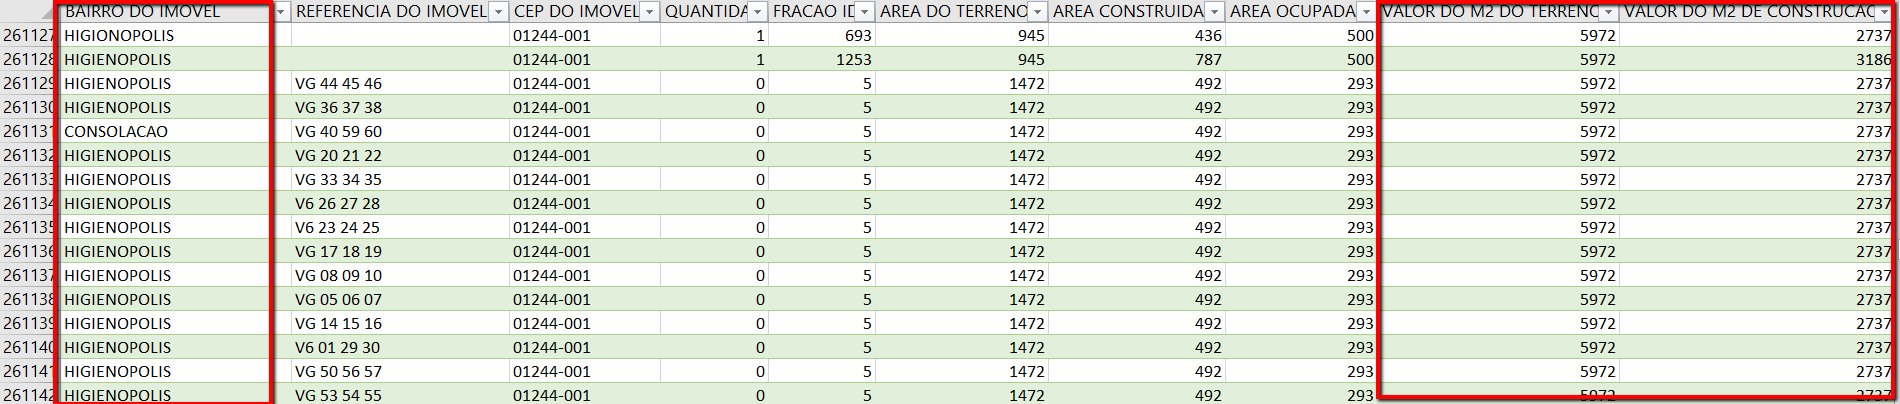


### [Foursquare API](https://developer.foursquare.com/docs) to retrieve venue locations
 
Foursquare holds the location for venues in different categories (bars, cinemas, supermarkets, museums, etc). 

### Import required libraries

In [1]:
!conda install -c conda-forge folium=0.10.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.10.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    folium-0.10.0              |             py_0          59 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be

In [2]:
!conda install fiona pyproj six
!pip install geopandas
!conda upgrade --all

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - fiona
    - pyproj
    - six


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    kealib-1.4.7               |       hd0c454d_6         175 KB
    poppler-0.65.0             |       h581218d_1         1.6 MB
    munch-2.3.2                |           py36_0          13 KB
    libnetcdf-4.6.1            |       h11d0813_2         1.3 MB
    gdal-2.3.3                 |   py36hbb2a789_0         1.3 MB
    hdf4-4.2.13                |       h3ca952b_2         916 KB
    freexl-1.0.5               |       h14c3975_0          44 KB
    xerces-c-3.2.2             |       h780794e_0         3.2 MB
    shapely-1.6.4              |   py36h86c5351_0         330 KB
    poppler-data-0.4.9         |                0         3.5 MB
    click-plugins-1.1.1        |             p

In [4]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from pandas.plotting import scatter_matrix
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import folium
import types
import os
import io
import json
import requests
from botocore.client import Config
import ibm_boto3
from urllib.request import urlopen
import urllib.parse

### Import land value data

Import the data obtained from São Paulo's City Hall website. 

In [28]:
def loadLandValueData():
    dfs = []
    for i in range(1, 5):
      filename = 'iptu_part' + str(i) + '.csv'
      url="https://github.com/guilhermelemmi/landvalue-sp/raw/master/data/" + filename
      #s=requests.get(url).content#
      c=pd.read_csv(url, encoding='iso-8859-1')
      dfs.append(c)
    return pd.concat(dfs, sort=True)

In [29]:
landvalueDF = loadLandValueData()
landvalueDF.shape

(3219739, 19)

### Data wrangling and cleanup

Discard some columns that will not be relevant and translate the remaining columns:

In [30]:
landvalueDF.drop(columns=[   
    'CEP DO IMOVEL',
    'COMPLEMENTO DO IMOVEL',
    'NOME DE LOGRADOURO DO IMOVEL',
    'NUMERO DO IMOVEL',
    'REFERENCIA DO IMOVEL'
], inplace=True)

In [31]:
landvalueDF.rename(columns={
    'ANO DA CONSTRUCAO CORRIGIDO':'CONSTRUCTION YEAR',
    'AREA CONSTRUIDA':'CONSTRUCTED AREA',
    'AREA DO TERRENO':'TOTAL AREA',
    'AREA OCUPADA':'SOIL OCCUPATION',
    'BAIRRO DO IMOVEL':'NEIGHBOURHOOD',
    'FATOR DE OBSOLESCENCIA':'OBSOLESCENCE FACTOR',
    'FRACAO IDEAL':'MINIMUN FRACTION',
    'QUANTIDADE DE ESQUINAS/FRENTES':'NUMBER OF FACADES',
    'QUANTIDADE DE PAVIMENTOS':'NUMBER OF FLOORS',
    'TIPO DE PADRAO DA CONSTRUCAO':'CONSTRUCTION TYPE',
    'TIPO DE TERRENO':'LAND POSITION',
    'TIPO DE USO DO IMOVEL':'TYPE',    
    'VALOR DO M2 DE CONSTRUCAO':'CONSTRUCTED M2 PRICE',
    'VALOR DO M2 DO TERRENO':'BARE M2 PRICE'
}, inplace=True)

Keep only records belonging to districts that are known:

In [32]:
districts = ["BELA VISTA","LIBERDADE","PARI","MOOCA","VILA ANDRADE","CAMBUCI","ITAIM BIBI","CONSOLACAO","PINHEIROS","VILA LEOPOLDINA","CAMPO LIMPO","MORUMBI","IPIRANGA","RAPOSO TAVARES","JARDIM PAULISTA","RIO PEQUENO","ALTO DE PINHEIROS","CURSINO","REPUBLICA","JABAQUARA","BELEM","CIDADE ADEMAR","CAMPO BELO","VILA MARIANA","VILA PRUDENTE","VILA GUILHERME","SANTANA","PERDIZES","VILA FORMOSA","SANTO AMARO","LAPA","SE","ERMELINO MATARAZZO","CASA VERDE","ANHANGUERA","VILA MEDEIROS","VILA MARIA","PERUS","BARRA FUNDA","MANDAQUI","ARICANDUVA","TUCURUVI","PENHA","SAPOPEMBA","PIRITUBA","CACHOEIRINHA","MOEMA","PARQUE DO CARMO","IGUATEMI","VILA MATILDE","ARTUR ALVIM","ITAQUERA","PONTE RASA","VILA JACUI","JAGUARA","LAJEADO","GUAIANASES","CIDADE TIRADENTES","ITAIM PAULISTA","CARRAO","JARDIM HELENA","PARELHEIROS","MARSILAC","SOCORRO","PEDREIRA","CIDADE DUTRA","CAMPO GRANDE","BOM RETIRO","VILA SONIA","JAGUARE","JARDIM SAO LUIS","JARDIM ANGELA","AGUA RASA","CAPAO REDONDO","LIMAO","SACOMA","SAUDE","SANTA CECILIA","TATUAPE","SAO LUCAS","BUTANTA","SAO DOMINGOS","JARAGUA","BRAS","FREGUESIA DO O","BRASILANDIA","TREMEMBE","JACANA","CANGAIBA","CIDADE LIDER","SAO MATEUS","SAO RAFAEL","JOSE BONIFACIO","SAO MIGUEL","GRAJAU","VILA CURUCA"]
landvalueDF = landvalueDF[landvalueDF['NEIGHBOURHOOD'].isin(districts)]
landvalueDF.head()

,CONSTRUCTION YEAR,CONSTRUCTED AREA,TOTAL AREA,SOIL OCCUPATION,NEIGHBOURHOOD,OBSOLESCENCE FACTOR,MINIMUN FRACTION,NUMBER OF FACADES,NUMBER OF FLOORS,CONSTRUCTION TYPE,LAND POSITION,TYPE,M2 PRICE
5,1954,1804,310,285,BOM RETIRO,2,1,0,8,Residencial vertical - padrão C,Normal,"Prédio de apartamento, não em condomínio, de u...",1939.0
170,1924,100,116,92,BOM RETIRO,2,1,0,1,Residencial horizontal - padrão C,Normal,Residência,1257.5
296,1970,280,148,140,SANTANA,46,1,2,2,Comercial horizontal - padrão B,De duas ou mais frentes,Loja,1225.0
344,1970,300,200,150,BARRA FUNDA,46,1,0,2,Comercial horizontal - padrão B,Normal,Loja e residência (predominância comercial),1208.0
411,1961,175,300,155,BOM RETIRO,3,13,0,7,Comercial vertical - padrão B,Normal,Loja em edifício em condomínio (unidade autônoma),1410.5


Merge the two M2 Price columns into a single column with their mean value:

In [33]:
landvalueDF['M2 PRICE'] = (landvalueDF['CONSTRUCTED M2 PRICE'] + landvalueDF['BARE M2 PRICE']) / 2
landvalueDF.drop(columns=[
    'CONSTRUCTED M2 PRICE',
    'BARE M2 PRICE'
], inplace=True)
landvalueDF.head()

KeyError: 'CONSTRUCTED M2 PRICE'

### Exploratory Data Analysis

Check column types:

In [28]:
landvalueDF.dtypes

CONSTRUCTION YEAR        int64
CONSTRUCTED AREA         int64
TOTAL AREA               int64
SOIL OCCUPATION          int64
NEIGHBOURHOOD           object
OBSOLESCENCE FACTOR      int64
MINIMUN FRACTION         int64
NUMBER OF FACADES        int64
NUMBER OF FLOORS         int64
CONSTRUCTION TYPE       object
LAND POSITION           object
TYPE                    object
M2 PRICE               float64
dtype: object

Let's examine our data:

In [25]:
landvalueDF['M2 PRICE'].astype(str).value_counts()

1802.0    2400
581.0     1254
2128.5    1146
742.0     1056
1154.0    1047
          ... 
4190.0       1
4121.5       1
4127.0       1
4844.0       1
3400.0       1
Name: M2 PRICE, Length: 8283, dtype: int64

There are many different price values, enough for us to deal with it as a continuous value.

Let's check the most expensive M2 Prices in the data:

In [34]:
landvalueDF.sort_values(by ='M2 PRICE', ascending=False).head(10)

,CONSTRUCTION YEAR,CONSTRUCTED AREA,TOTAL AREA,SOIL OCCUPATION,NEIGHBOURHOOD,OBSOLESCENCE FACTOR,MINIMUN FRACTION,NUMBER OF FACADES,NUMBER OF FLOORS,CONSTRUCTION TYPE,LAND POSITION,TYPE,M2 PRICE
165166,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165169,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165168,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165171,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165172,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165167,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165145,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165148,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165149,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165150,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0


Let's plot the boxplot distribution of M2 Prices for each district but let's also remove some outliers from data to improve visualization.

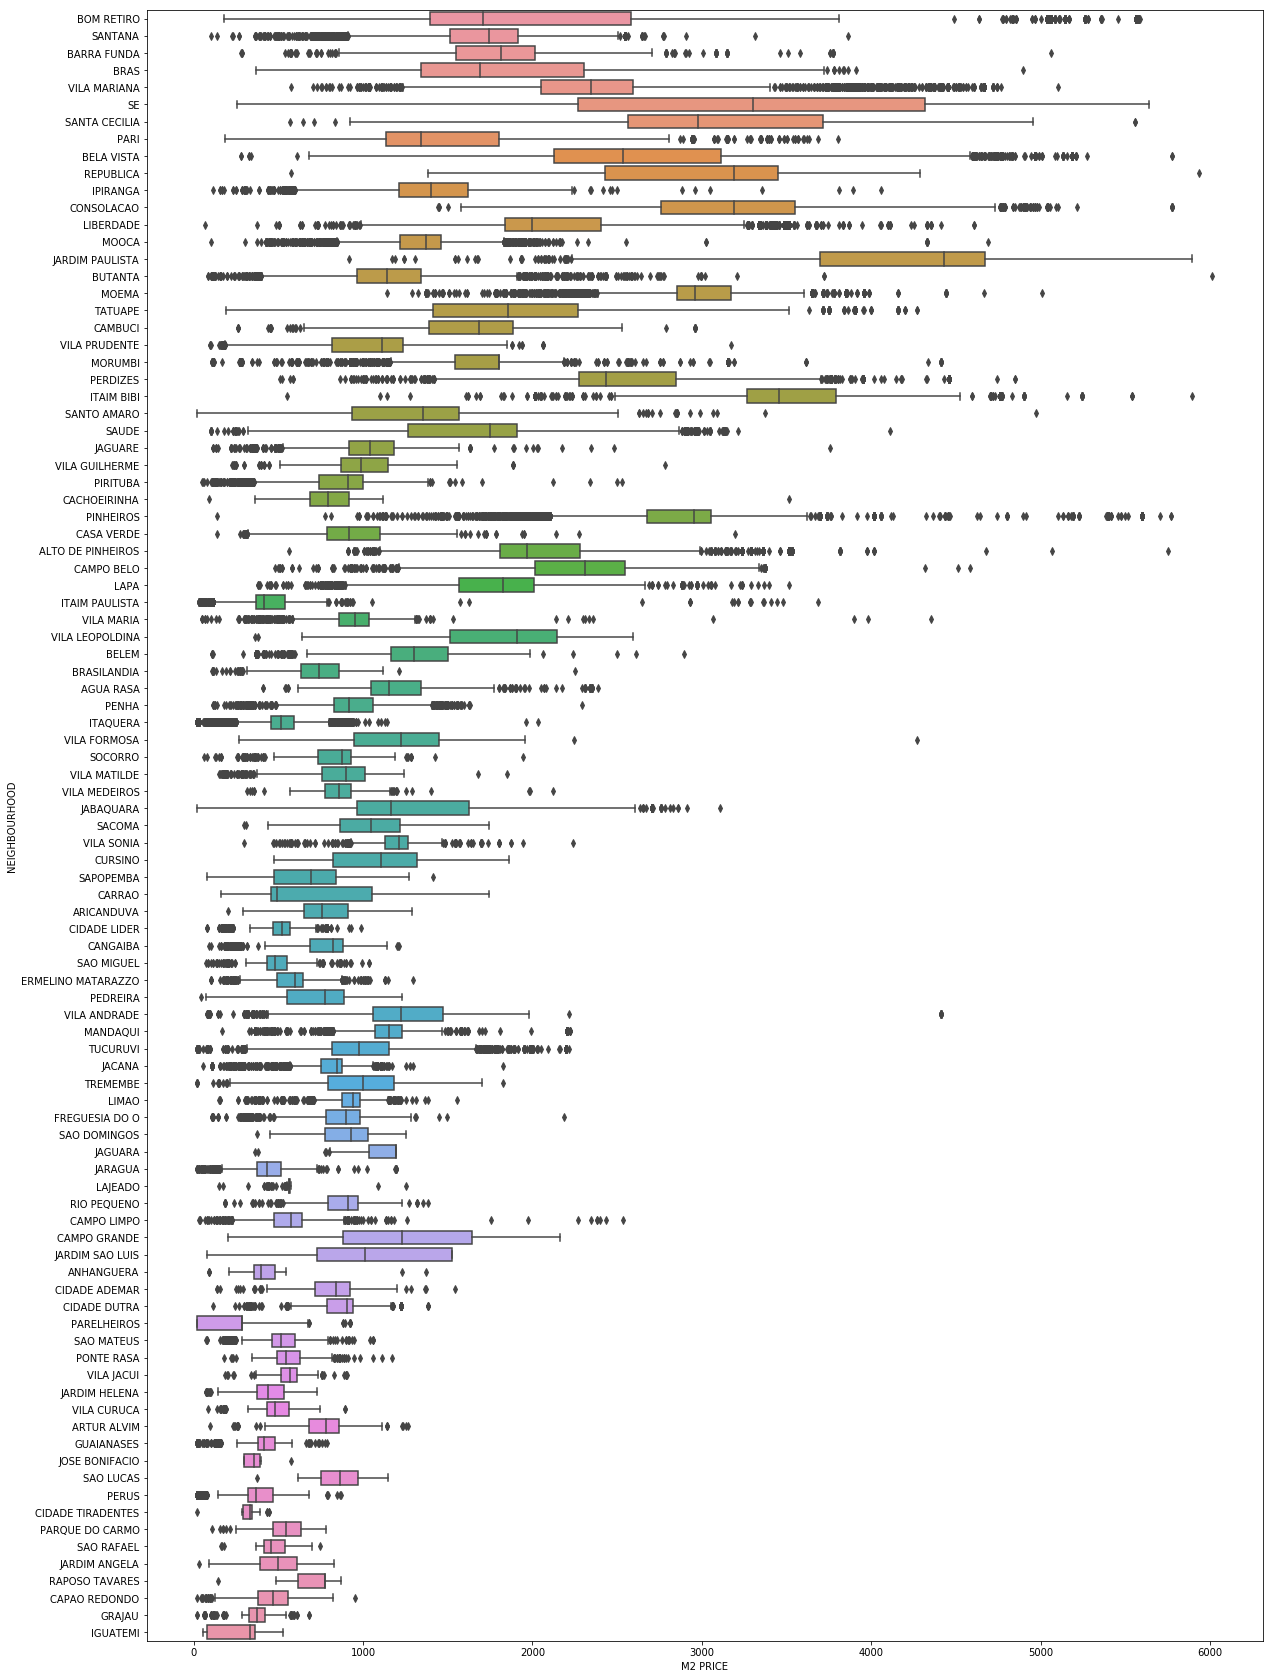

In [41]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-3*iqr
    fence_high = q3+3*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

neighbourhoodPricesDF = landvalueDF[['M2 PRICE', 'NEIGHBOURHOOD']]
neighbourhoodPricesDF = remove_outlier(neighbourhoodPricesDF, 'M2 PRICE')

plt.figure(figsize=(20, 30))
sns.boxplot(x="M2 PRICE", y="NEIGHBOURHOOD", data=neighbourhoodPricesDF);

### Plot mean district prices in a Choroplet Map

Get mean value for each district and print the top 10 priciest districts:

In [35]:
meanLandvalueDF = landvalueDF.groupby(landvalueDF['NEIGHBOURHOOD'], as_index=False)['M2 PRICE'].mean()
meanLandvalueDF.sort_values('M2 PRICE', ascending=False).head(10)

,NEIGHBOURHOOD,M2 PRICE
43,JARDIM PAULISTA,4266.389269
6,BELA VISTA,3554.064977
33,ITAIM BIBI,3553.014634
78,SE,3385.438525
25,CONSOLACAO,3234.804929
61,PINHEIROS,3166.775785
68,SANTA CECILIA,3049.545027
65,REPUBLICA,3024.033462
51,MOEMA,2992.528077
59,PERDIZES,2563.042978


Load districts GEOJSON and plot Choroplet map with mean district prices.

In [36]:
urlGeoJson = 'https://raw.githubusercontent.com/guilhermelemmi/landvalue-sp/master/data/distritos_sp.json'
geojsonFile = urlopen(urlGeoJson)
geojson = json.loads(geojsonFile.read())

In [40]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(meanLandvalueDF['M2 PRICE'].min(),
                              meanLandvalueDF['M2 PRICE'].max(),
                              10, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

map = folium.Map(location=[-23.549896, -46.631258], zoom_start=12)

folium.Choropleth(
    geo_data=geojson,
    data=meanLandvalueDF,
    columns=['NEIGHBOURHOOD', 'M2 PRICE'],
    key_on='feature.properties.nomecaps',
    threshold_scale=threshold_scale,
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sao Paulo land value',
).add_to(map)

folium.LayerControl().add_to(map)
map

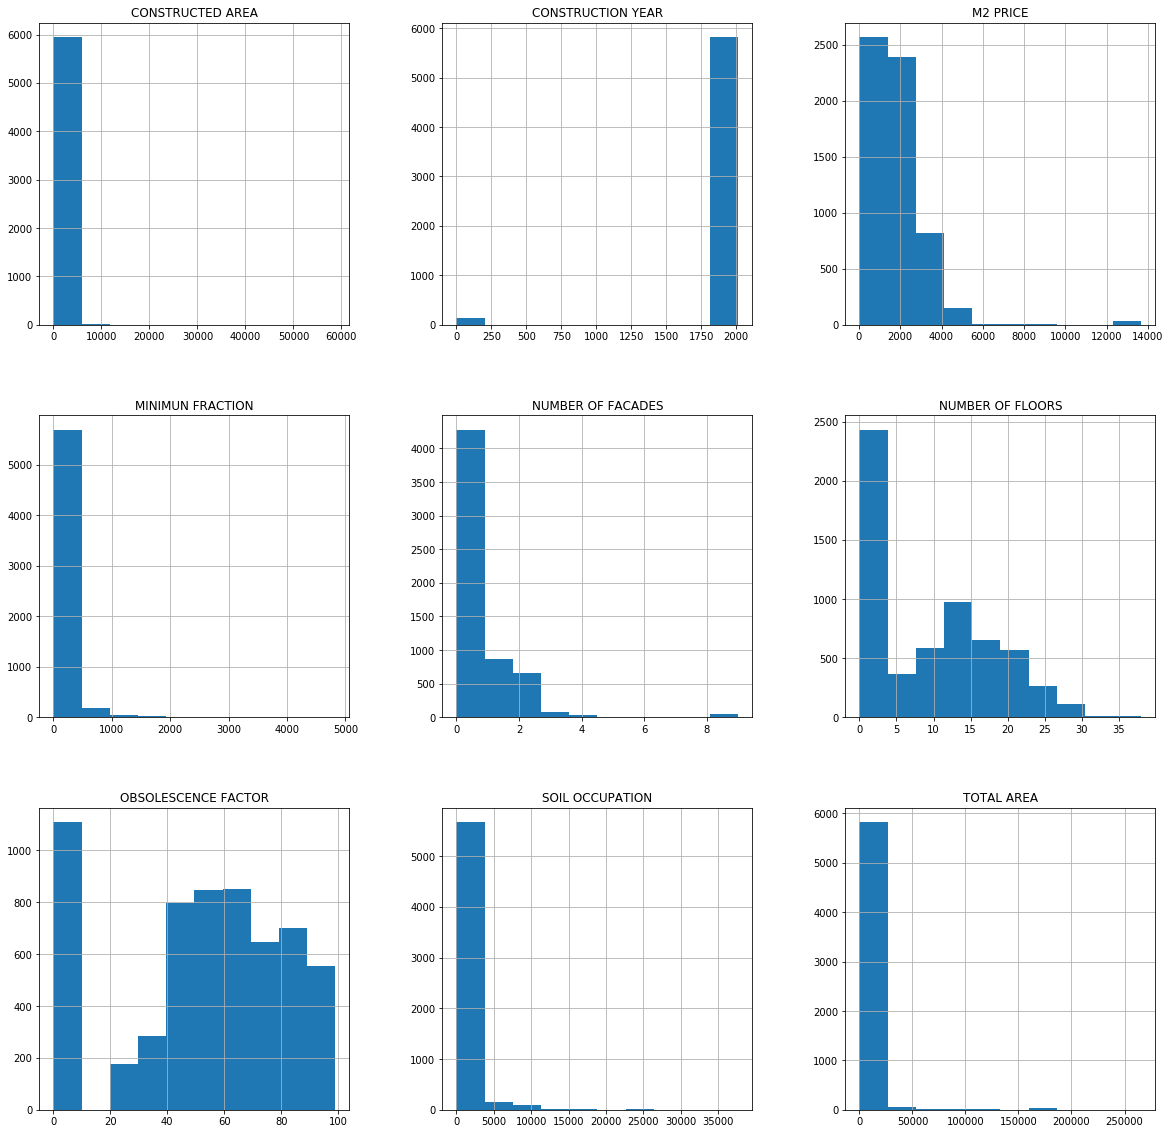

In [12]:
landvalueDF.hist(figsize=(20, 20));

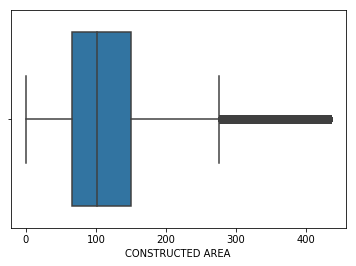

In [59]:
noOutliersDF = remove_outlier(landvalueDF, 'CONSTRUCTED AREA')
sns.boxplot(x="CONSTRUCTED AREA", data=noOutliersDF);

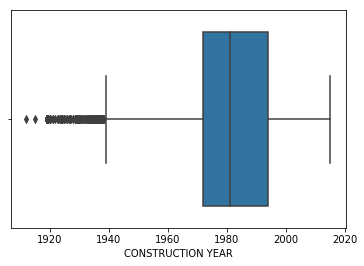

In [60]:
noOutliersDF = remove_outlier(noOutliersDF, 'CONSTRUCTION YEAR')
sns.boxplot(x="CONSTRUCTION YEAR", data=noOutliersDF);

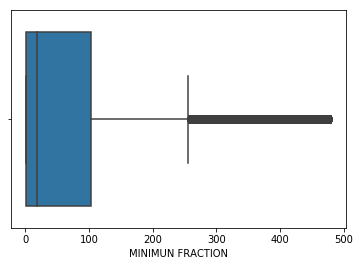

In [61]:
noOutliersDF = remove_outlier(noOutliersDF, 'MINIMUN FRACTION')
sns.boxplot(x='MINIMUN FRACTION', data=noOutliersDF);

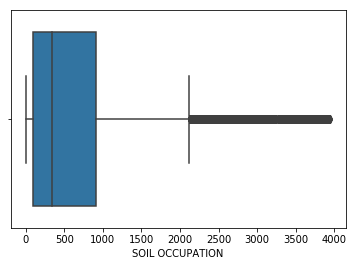

In [62]:
noOutliersDF = remove_outlier(noOutliersDF, 'SOIL OCCUPATION')
sns.boxplot(x='SOIL OCCUPATION', data=noOutliersDF);

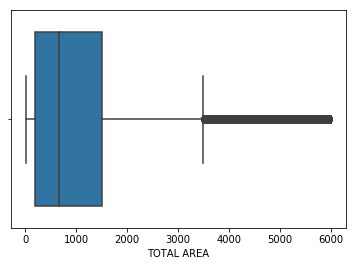

In [63]:
noOutliersDF = remove_outlier(noOutliersDF, 'TOTAL AREA')
sns.boxplot(x='TOTAL AREA', data=noOutliersDF);

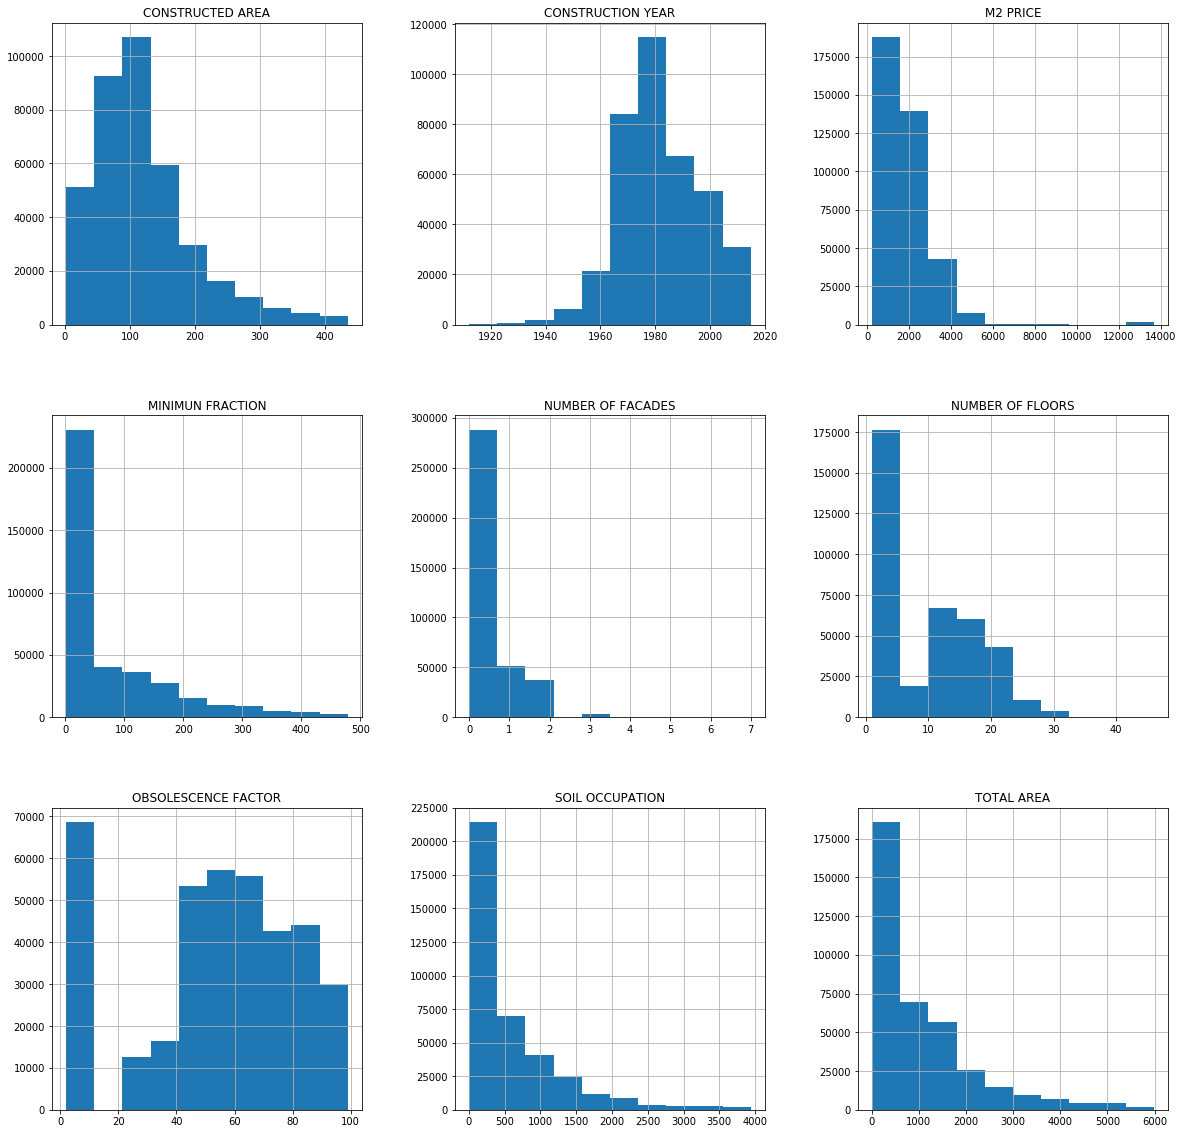

In [64]:
noOutliersDF.hist(figsize=(20, 20));

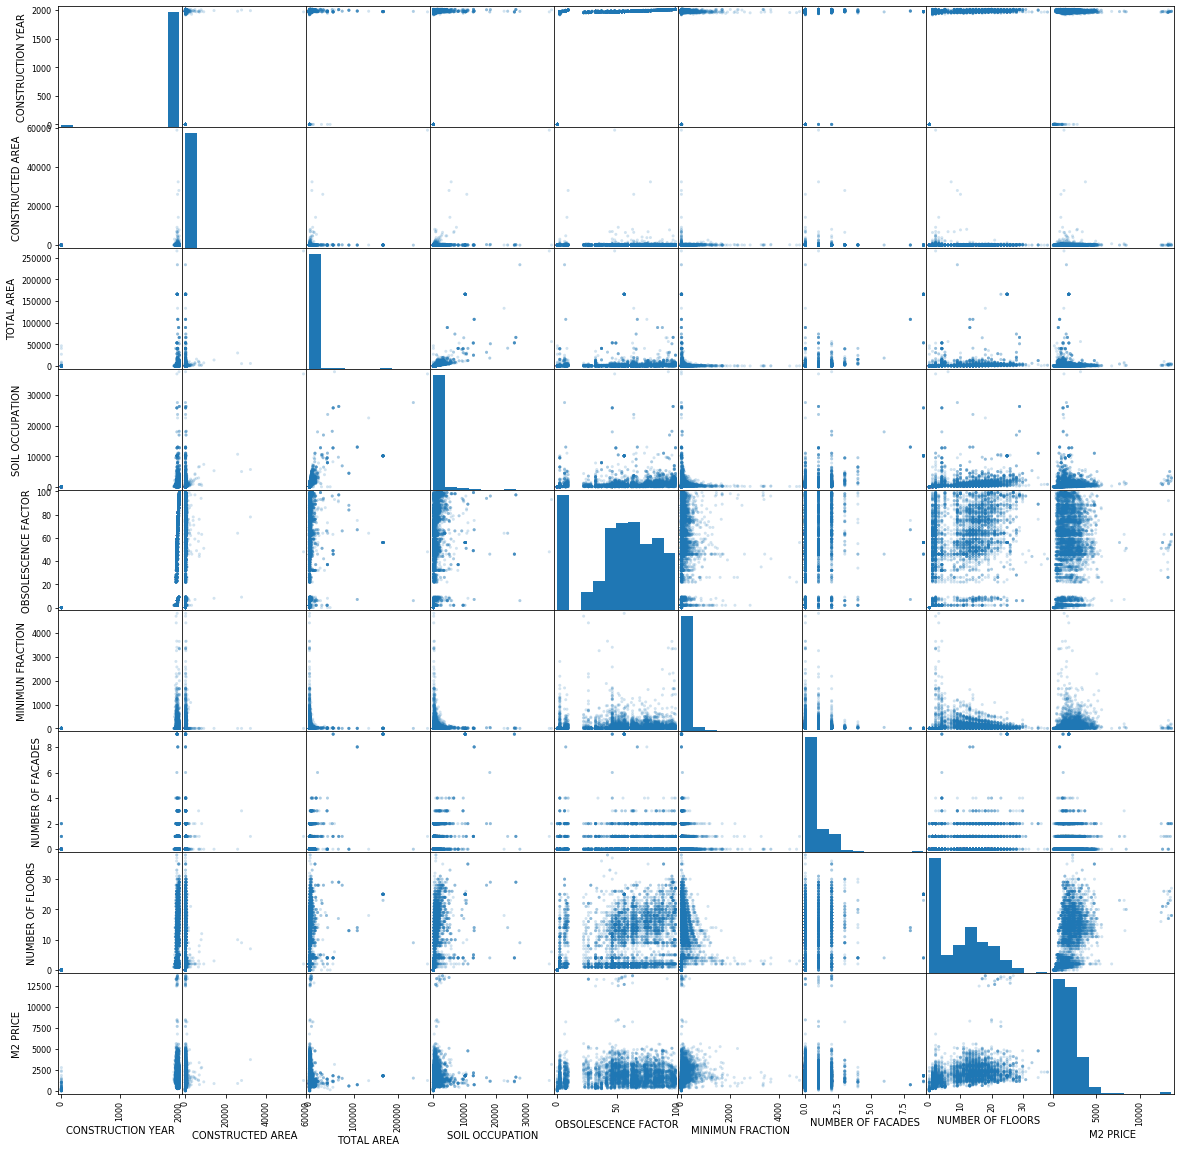

In [13]:
scatter_matrix(landvalueDF, alpha=0.2, figsize=(20, 20));

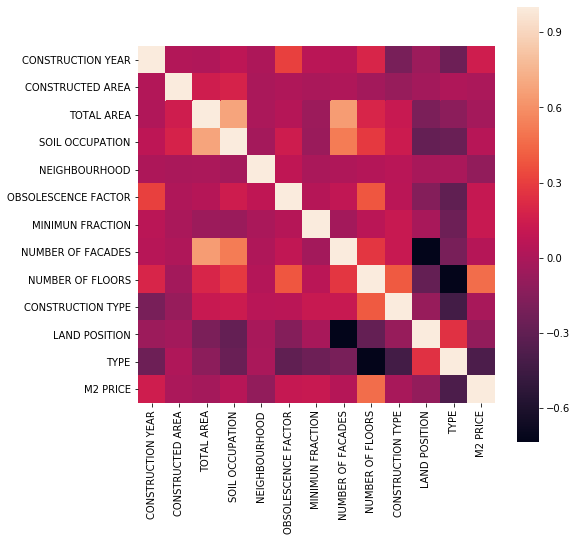

In [18]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(landvalueDF)
plt.figure(figsize=(8, 8));
sns.heatmap(encoded_data.corr(), square=True);
plt.show()

In [19]:
landvalueDF[['NUMBER OF FLOORS', 'M2 PRICE']].sample(10)

,NUMBER OF FLOORS,M2 PRICE
528924,1,639.5
828543,12,607.5
551552,2,649.0
587762,4,1364.0
310762,2,2113.0
590437,2,1728.5
404138,0,1018.0
88486,2,1060.5
504151,4,779.0
293049,2,2062.0


In [20]:
landvalueDF[['TYPE', 'M2 PRICE']].sample(10)

,TYPE,M2 PRICE
159357,Garagem (unidade autônoma) em edifício em cond...,3220.0
33169,Residência,798.5
694113,"Residência coletiva, exclusive cortiço (mais d...",2173.0
717080,Apartamento em condomínio,1136.5
56978,Apartamento em condomínio,1571.0
175548,Garagem (unidade autônoma) em edifício em cond...,3080.5
37949,Apartamento em condomínio,2888.5
353509,Apartamento em condomínio,1592.0
390821,Garagem (unidade autônoma) em edifício em cond...,1403.5
39833,Apartamento em condomínio,3140.0


In [21]:
encoded_data.sample(10)

,CONSTRUCTION YEAR,CONSTRUCTED AREA,TOTAL AREA,SOIL OCCUPATION,NEIGHBOURHOOD,OBSOLESCENCE FACTOR,MINIMUN FRACTION,NUMBER OF FACADES,NUMBER OF FLOORS,CONSTRUCTION TYPE,LAND POSITION,TYPE,M2 PRICE
439109,2002,64,1347,984,63,88,79,0,14,8,4,6,3939.5
219120,1963,42,1720,860,24,33,29,0,15,23,5,0,2565.0
346717,1954,206,242,110,57,2,1,0,2,17,4,30,2779.5
668561,2013,33,2584,2051,64,98,14,2,8,8,0,11,1781.5
623868,1970,450,250,200,12,46,1,0,2,4,4,27,1502.0
610970,1966,111,2400,900,44,39,96,0,17,23,4,0,1836.0
459511,1990,120,991,928,55,75,16,2,16,23,0,0,2295.0
123755,1919,100,144,100,24,2,1,0,1,17,4,28,2254.0
224120,2010,409,51408,18191,10,96,29,2,29,24,0,0,1157.0
105363,1967,80,200,80,37,2,1,0,1,15,3,28,714.5


In [17]:
encoded_data.dtypes

CONSTRUCTION YEAR        int64
CONSTRUCTED AREA         int64
TOTAL AREA               int64
SOIL OCCUPATION          int64
NEIGHBOURHOOD            int64
OBSOLESCENCE FACTOR      int64
MINIMUN FRACTION         int64
NUMBER OF FACADES        int64
NUMBER OF FLOORS         int64
CONSTRUCTION TYPE        int64
LAND POSITION            int64
TYPE                     int64
M2 PRICE               float64
dtype: object

In [22]:
# Split and scale the data
encoded_data, encoders = number_encode_features(landvalueDF)
X = encoded_data[['NUMBER OF FLOORS']]
y = encoded_data[['M2 PRICE']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
y_pred = model.predict(X_test)

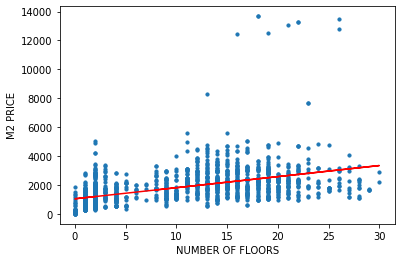

In [25]:
plt.scatter(X_test, y_test, s=10)
plt.xlabel('NUMBER OF FLOORS')
plt.ylabel('M2 PRICE')

# predicted values
plt.plot(X_test, y_pred, color='r')
plt.show()

In [26]:
mse = mean_squared_error(y_test, y_pred)
mse

1403644.172479759

In [27]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

1184.7548997492092

In [28]:
r2 = r2_score(y_test, y_pred)
r2

0.23190756308432614

### Multiple Linear Regression with One Hot Encoding

In [30]:
# Copy the original data
features = landvalueDF.copy()

# Select the numeric columns
numeric_subset = landvalueDF.select_dtypes('number')
categorical_subset = landvalueDF.select_dtypes('object')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
features.head()

,CONSTRUCTION YEAR,CONSTRUCTED AREA,TOTAL AREA,SOIL OCCUPATION,OBSOLESCENCE FACTOR,MINIMUN FRACTION,NUMBER OF FACADES,NUMBER OF FLOORS,M2 PRICE,NEIGHBOURHOOD_AGUA RASA,...,"TYPE_Outras edificações de uso especial, com utilização múltipla",TYPE_Posto de serviço,"TYPE_Prédio de apartamento, não em condomínio, de uso exclusivamente residencial","TYPE_Prédio de apartamento, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios), com ou sem loja (predominância residencial)","TYPE_Prédio de escritório ou consultório, não em condomínio, com ou sem lojas",TYPE_Residência,"TYPE_Residência coletiva, exclusive cortiço (mais de uma residência no lote)",TYPE_Residência e outro uso (predominância residencial),TYPE_Templo,TYPE_Terreno
407883,1995,100,122,100,81,1,0,1,924.0,0,...,0,0,0,0,0,0,0,0,0,0
131151,1973,63,800,700,51,11,1,13,2657.0,0,...,0,0,0,0,0,0,0,0,0,0
606407,1970,25,750,480,46,34,1,11,2257.5,0,...,0,0,0,0,0,0,0,0,0,0
682363,1994,183,1294,1185,8,184,0,15,2617.5,0,...,0,0,0,0,0,0,0,0,0,0
160585,1969,152,650,400,44,76,0,7,2230.0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Split and scale the data
y = features[["M2 PRICE"]]

X_train, X_test, y_train, y_test = train_test_split(features[features.columns.drop("M2 PRICE")], y, test_size=0.25, random_state=42)

#scaler = preprocessing.StandardScaler()

#X_train
#X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
#X_test = scaler.transform(X_test)

In [33]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
y_pred = model.predict(X_test)

'RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred))

'RMSE: 806.25'

In [35]:
rmse = mean_squared_error(y_test, y_pred)
rmse

650039.7020975898

In [36]:
r2 = r2_score(y_test, y_pred)
r2

0.6442897789444736

### Clean up land value data
Clean up IPTU data leaving only rows that belong to valid districts.

We'll be using only residential prices in our prediction, so let's strip other types out.

## Get Venues from Foursquare

### Get Districts Centroid Coordinates

In [42]:
with open('districts.geojson', "w") as file:
    file.write(json.dumps(geojson))
zones = gpd.read_file('districts.geojson')

for i in range(0,len(geojson['features'])):
    zones.loc[i,'centroid_lon'] = zones.geometry.centroid.x.iloc[i]
    zones.loc[i,'centroid_lat'] = zones.geometry.centroid.y.iloc[i]

In [43]:
zones

,cartodb_id,id,mun_sigla,mun_nome,cod_ibge,sigla,nome,nomecaps,incidencia,geometry,centroid_lon,centroid_lat
0,34,22,SAO,SAO PAULO,355030807,BVI,Bela Vista,BELA VISTA,8.5,"(POLYGON ((-46.648614 -23.567189, -46.653394 -...",-46.647027,-23.560400
1,38,24,SAO,SAO PAULO,355030849,LIB,Liberdade,LIBERDADE,7.1,"(POLYGON ((-46.640735 -23.572888, -46.640488 -...",-46.631528,-23.566521
2,42,259,SAO,SAO PAULO,355030856,PRI,Pari,PARI,16.4,"(POLYGON ((-46.624928 -23.519002, -46.623455 -...",-46.617179,-23.526806
3,21,30,SAO,SAO PAULO,355030853,MOO,Mooca,MOOCA,5.1,"(POLYGON ((-46.603601 -23.566726, -46.604565 -...",-46.596134,-23.560910
4,8,3,SAO,SAO PAULO,355030883,VAN,Vila Andrade,VILA ANDRADE,2.2,"(POLYGON ((-46.727635 -23.61106, -46.721546 -2...",-46.728013,-23.625839
5,19,29,SAO,SAO PAULO,355030814,CMB,Cambuci,CAMBUCI,5.2,"(POLYGON ((-46.617807 -23.578618, -46.618909 -...",-46.616623,-23.563925
6,29,9,SAO,SAO PAULO,355030835,IBI,Itaim Bibi,ITAIM BIBI,9.5,"(POLYGON ((-46.70093 -23.61956, -46.700576 -23...",-46.685138,-23.601715
7,66,66,SAO,SAO PAULO,355030826,CON,Consolação,CONSOLACAO,1.7,"(POLYGON ((-46.65861 -23.558781, -46.662576 -2...",-46.659763,-23.548199
8,32,12,SAO,SAO PAULO,355030862,PIN,Pinheiros,PINHEIROS,4.6,"(POLYGON ((-46.676969 -23.550733, -46.678303 -...",-46.688358,-23.565979
9,6,116,SAO,SAO PAULO,355030888,VLE,Vila Leopoldina,VILA LEOPOLDINA,9.7,"(POLYGON ((-46.73427 -23.545335, -46.746965 -2...",-46.734131,-23.528787


### Plot map with districts and centroids

In [44]:
for lat, long in zip(zones['centroid_lat'], zones['centroid_lon']):      
    folium.CircleMarker(
        [lat, long],
        radius = 3,
        fill = True,
        fill_opacity = 0.5,        
    ).add_to(map) 
map

### Load Venues close to each centroid

In [45]:
# The code was removed by Watson Studio for sharing.

In [64]:
geojson['features'][0]['geometry']['coordinates']

[[[[-46.648614, -23.567189],
   [-46.653394, -23.563265],
   [-46.65861, -23.558781],
   [-46.655482, -23.554765],
   [-46.6554, -23.554698],
   [-46.650411, -23.552023],
   [-46.649904, -23.551756],
   [-46.647387, -23.550947],
   [-46.646899, -23.551161],
   [-46.646683, -23.550765],
   [-46.646456, -23.550576],
   [-46.646039, -23.550397],
   [-46.645077, -23.552982],
   [-46.644912, -23.553369],
   [-46.644738, -23.553642],
   [-46.64446, -23.553888],
   [-46.644176, -23.554064],
   [-46.642248, -23.554803],
   [-46.64161, -23.554973],
   [-46.639819, -23.555266],
   [-46.639603, -23.555888],
   [-46.639253, -23.55536],
   [-46.637277, -23.555709],
   [-46.638272, -23.558304],
   [-46.638481, -23.558662],
   [-46.639175, -23.559671],
   [-46.639494, -23.560322],
   [-46.639639, -23.560699],
   [-46.6397, -23.561077],
   [-46.639896, -23.562973],
   [-46.640081, -23.563963],
   [-46.640287, -23.564878],
   [-46.640318, -23.565576],
   [-46.640246, -23.566359],
   [-46.640215, -23.56

In [78]:
def get_polygon_str(geometry) :
    rtn = ''
    for i in range(0,len(geometry['coordinates'][0][0])):
        rtn += str(geometry['coordinates'][0][0][i][0]) + ',' + str(geometry['coordinates'][0][0][i][1]) + ';'
    return rtn[:-1]

In [71]:
len(geojson['features'][0]['geometry']['coordinates'])

1

In [79]:
geometry_str = urllib.parse.quote(get_polygon_str(geojson['features'][0]['geometry']))
geometry_str

'-46.648614%2C-23.567189%3B-46.653394%2C-23.563265%3B-46.65861%2C-23.558781%3B-46.655482%2C-23.554765%3B-46.6554%2C-23.554698%3B-46.650411%2C-23.552023%3B-46.649904%2C-23.551756%3B-46.647387%2C-23.550947%3B-46.646899%2C-23.551161%3B-46.646683%2C-23.550765%3B-46.646456%2C-23.550576%3B-46.646039%2C-23.550397%3B-46.645077%2C-23.552982%3B-46.644912%2C-23.553369%3B-46.644738%2C-23.553642%3B-46.64446%2C-23.553888%3B-46.644176%2C-23.554064%3B-46.642248%2C-23.554803%3B-46.64161%2C-23.554973%3B-46.639819%2C-23.555266%3B-46.639603%2C-23.555888%3B-46.639253%2C-23.55536%3B-46.637277%2C-23.555709%3B-46.638272%2C-23.558304%3B-46.638481%2C-23.558662%3B-46.639175%2C-23.559671%3B-46.639494%2C-23.560322%3B-46.639639%2C-23.560699%3B-46.6397%2C-23.561077%3B-46.639896%2C-23.562973%3B-46.640081%2C-23.563963%3B-46.640287%2C-23.564878%3B-46.640318%2C-23.565576%3B-46.640246%2C-23.566359%3B-46.640215%2C-23.567312%3B-46.640488%2C-23.570322%3B-46.640735%2C-23.572888%3B-46.641486%2C-23.572605%3B-46.642697%2C-23.57

In [80]:
LIMIT=1000
radius = 3000
geometry_str = urllib.parse.quote(get_polygon_str(geojson['features'][0]['geometry']))
#for lat, lon in zip(zones['centroid_lat'], zones['centroid_lon']): 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&polygon={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    geometry_str, 
    LIMIT)
#results = requests.get(url).json()
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=MBLG0GXG1YLBHH2PW1JVEOEHF2EZEUOHAHFSTSEQPZWYVSLK&client_secret=QT4CBHY1WBX4PCG5TOPPRE1SFOGD3JKZC1PXDTSXWAK3FPJF&v=20190701&polygon=-46.648614%2C-23.567189%3B-46.653394%2C-23.563265%3B-46.65861%2C-23.558781%3B-46.655482%2C-23.554765%3B-46.6554%2C-23.554698%3B-46.650411%2C-23.552023%3B-46.649904%2C-23.551756%3B-46.647387%2C-23.550947%3B-46.646899%2C-23.551161%3B-46.646683%2C-23.550765%3B-46.646456%2C-23.550576%3B-46.646039%2C-23.550397%3B-46.645077%2C-23.552982%3B-46.644912%2C-23.553369%3B-46.644738%2C-23.553642%3B-46.64446%2C-23.553888%3B-46.644176%2C-23.554064%3B-46.642248%2C-23.554803%3B-46.64161%2C-23.554973%3B-46.639819%2C-23.555266%3B-46.639603%2C-23.555888%3B-46.639253%2C-23.55536%3B-46.637277%2C-23.555709%3B-46.638272%2C-23.558304%3B-46.638481%2C-23.558662%3B-46.639175%2C-23.559671%3B-46.639494%2C-23.560322%3B-46.639639%2C-23.560699%3B-46.6397%2C-23.561077%3B-46.639896%2C-23.562973%3B-46.640081%2C-23.563963%3B-46.640287%2C-

In [40]:
LIMIT=1000
radius = 3000

#for lat, lon in zip(zones['centroid_lat'], zones['centroid_lon']):  
&polygon=37.80463017025873%2C-122.42786407470703%3B37.802595683318046%2C-122.42374420166016%3B37.798662182986945%2C-122.42219924926756%3B37.79676317682161%2C-122.43009567260741%3B37.79255806087506%2C-122.43919372558592%3B37.79255806087506%2C-122.44314193725585%3B37.79513541839677%2C-122.44588851928712%3B37.803273851858656%2C-122.44709014892577%3B37.80286695148153%2C-122.44279861450195%3B37.805850835522065%2C-122.43370056152344%3B37.80463017025873%2C-122.42786407470703
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    zones.loc[0]['centroid_lat'], 
    zones.loc[0]['centroid_lon'], 
    radius, 
    LIMIT)
#results = requests.get(url).json()
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=MBLG0GXG1YLBHH2PW1JVEOEHF2EZEUOHAHFSTSEQPZWYVSLK&client_secret=QT4CBHY1WBX4PCG5TOPPRE1SFOGD3JKZC1PXDTSXWAK3FPJF&v=20190701&ll=-23.56040027667004,-46.64702724763833&radius=3000&limit=1000'

In [44]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [82]:
url
# results = requests.get(url).json()
# results['response']
# venues = results['response']['groups'][0]['items']
    
# nearby_venues = json_normalize(venues) # flatten JSON

# # filter columns
# filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
# nearby_venues =nearby_venues.loc[:, filtered_columns]

# # filter the category for each row
# nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# # clean columns
# nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# nearby_venues.head(100)

'https://api.foursquare.com/v2/venues/explore?&client_id=MBLG0GXG1YLBHH2PW1JVEOEHF2EZEUOHAHFSTSEQPZWYVSLK&client_secret=QT4CBHY1WBX4PCG5TOPPRE1SFOGD3JKZC1PXDTSXWAK3FPJF&v=20190701&polygon=-46.648614%2C-23.567189%3B-46.653394%2C-23.563265%3B-46.65861%2C-23.558781%3B-46.655482%2C-23.554765%3B-46.6554%2C-23.554698%3B-46.650411%2C-23.552023%3B-46.649904%2C-23.551756%3B-46.647387%2C-23.550947%3B-46.646899%2C-23.551161%3B-46.646683%2C-23.550765%3B-46.646456%2C-23.550576%3B-46.646039%2C-23.550397%3B-46.645077%2C-23.552982%3B-46.644912%2C-23.553369%3B-46.644738%2C-23.553642%3B-46.64446%2C-23.553888%3B-46.644176%2C-23.554064%3B-46.642248%2C-23.554803%3B-46.64161%2C-23.554973%3B-46.639819%2C-23.555266%3B-46.639603%2C-23.555888%3B-46.639253%2C-23.55536%3B-46.637277%2C-23.555709%3B-46.638272%2C-23.558304%3B-46.638481%2C-23.558662%3B-46.639175%2C-23.559671%3B-46.639494%2C-23.560322%3B-46.639639%2C-23.560699%3B-46.6397%2C-23.561077%3B-46.639896%2C-23.562973%3B-46.640081%2C-23.563963%3B-46.640287%2C-

In [47]:
for lat, long in zip(nearby_venues['lat'], nearby_venues['lng']):      
    folium.CircleMarker(
        [lat, long],
        radius = 2,
        color='crimson',
        fill = True,
        fill_opacity = 0.5,        
    ).add_to(map) 
map